Notebook for cleaning (real-world) graphs from unrelated roads and apartment areas.

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline
# from imposm.parser import OSMParser
import networkx as nx
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sbn
import math
from tqdm import *
import re
import json
from shapely.geometry import MultiPolygon, Polygon, Point
import geopandas as gp
from sklearn.neighbors import NearestNeighbors
from scipy import spatial

import sys
sys.path.append('../scripts')
import helpers
import imp

storage_path = '/q/storage/alogins/fcla_data/real/cph_multicap/all/'

In [144]:
imp.reload(helpers)

<module 'helpers' from '../scripts/helpers.py'>

# Add potential facilities to a graph based on shops

In [ ]:
def get_hours(tags):
    amenities = "amenity::(fast_food|bar|bbq|biergarten|cafe|food_court|ice_cream|pub|restaurant)"
    m = re.search("opening_hours::[A-z- ]*(\d+):(\d+)-(\d+):(\d+)",tags)
    m2 = re.search(amenities,tags)
    if m and m2:
        return int(float(m.group(3)) + float(m.group(4))/60. - float(m.group(1)) - float(m.group(2))/60.)
    else:
        return -1

In [112]:
# load full graph and extract single points of interest
# nodes of a graph
shop_points = []
shop_points_tags = []
    
with open(storage_path + 'cph_full_2.ntw', 'r') as f:
    t = f.readline().split()
    graph_id = int(t[0])
    nodes = int(t[1])
    edges = int(t[2])
    for i in range(edges):
        f.readline()
        # just skip, not interested in edges
    for i in range(nodes):
        info = f.readline().split()
        try:
            lat = float(info[0])
            lon = float(info[1])
            if (len(info) > 2):
                hours = get_hours(info[2])
                if (hours > -1):
                    shop_points.append((lat, lon))
                    shop_points_tags.append(hours)
        except ValueError:
            print("Error in graph node info: ")
            print(info)
            print("Probably you need to remove new line charachter from graph file")

In [151]:
# load pickled graph after cleaning
G = pkl.load(open(storage_path + 'cph_full_2.pkl'))

TypeError: 'str' does not support the buffer interface

In [113]:
# map shops
graph_points = []
for node in G.nodes_iter():
    try:
        graph_points.append((float(G.node[node]['lat']), float(G.node[node]['lon'])))
    except ValueError:
        print(G.node[node])
    
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(graph_points)
distances, indices = nbrs.kneighbors(shop_points)

hour_attr = {}
for i in range(len(shop_points)):
    hour_attr[indices[i][0]] = shop_points_tags[i]

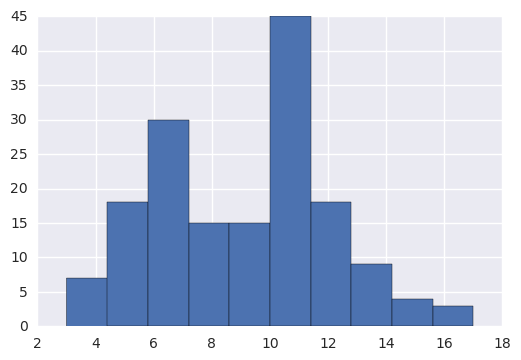

In [114]:
pd.Series(hour_attr).hist()

In [115]:
# export shops as customers
capacity_scale = 1
df = pd.Series(capacity_scale*pd.Series(hour_attr),dtype=int)
df.to_csv("facility_location_hours_full.csv",sep=" ")
df.mean(), len(df), df.mean() * len(df)

(9.0426829268292686, 164, 1483.0)

## Export with population-based customers and potential facilities

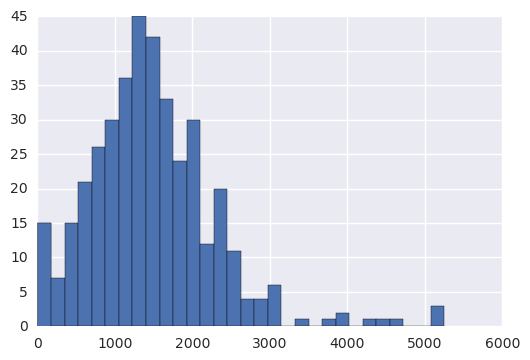

In [116]:
# map population of the latest year to each of regions
population = pd.read_csv(storage_path + "cph-population.csv")
population = population[population["AAR"] == population["AAR"].max()]

pop_map = population[['RODE','PERSONER']].groupby("RODE",as_index=False).sum()
pop_map['PERSONER'].hist(bins=30)

In [117]:
points = []
for node in G.nodes_iter():
    points.append(Point(float(G.node[node]['lat']), float(G.node[node]['lon'])))
geopoints = gp.GeoDataFrame(points, columns=['geometry'])

In [ ]:
# this doesn't work if rtree is installed for python :(

# glaciers = gp.GeoDataFrame.from_file(storage_path + 'cph-regions.geojson')
# f = open(storage_path + "cph-regions.geojson","r")
# data = json.loads(f.read())
# for j in range(len(data['features'])):
#     for i in range(len(data['features'][j]['geometry']['coordinates'])):
#         data['features'][j]['geometry']['coordinates'][i][0] = transform_coords(data['features'][j]['geometry']['coordinates'][i][0])
# with open("tmp2.txt","w") as f:
#     f.write(json.dumps(data))

In [118]:
glaciers = gp.GeoDataFrame.from_file("tmp2.txt")
glaciers.head()

,distrikt_nr,rode_nr,id,areal_m2,rodenavn,bydel,geometry
0,7,99,111,,Bellmans,Østerbro,"(POLYGON ((41912.59328344829 24908.8038512097,..."
1,1,17,9,,Holmens,Indre by,(POLYGON ((43427.88194038036 20642.09958605793...
2,22,227,255,,Flaskekroens,Valby,(POLYGON ((37617.75847267229 17278.01210023011...
3,1,2,12,,Bispegårdens,Indre by,(POLYGON ((42396.82955450325 20844.17562587633...
4,1,3,13,,Rådhusets,Indre by,(POLYGON ((42534.82700745332 20637.81031533494...


In [119]:
sjoin = gp.sjoin(geopoints, glaciers, how="inner", op='intersects')
sjoin.head()

,geometry,index_right,distrikt_nr,rode_nr,id,areal_m2,rodenavn,bydel
0,POINT (42186.5 20335.2),81,27,47,322,,Reventlows,Vesterbro-Kongens Enghave
459,POINT (42228.4 20162.7),81,27,47,322,,Reventlows,Vesterbro-Kongens Enghave
923,POINT (42345.3 20029.9),81,27,47,322,,Reventlows,Vesterbro-Kongens Enghave
1245,POINT (42333.8 19954.9),81,27,47,322,,Reventlows,Vesterbro-Kongens Enghave
1246,POINT (42185.1 20038.9),81,27,47,322,,Reventlows,Vesterbro-Kongens Enghave


In [18]:
#lat0 = 55.491 
# lon0 = 11.894

In [120]:
facility_fraction_in_region = {}
regions = glaciers["rode_nr"].unique()
for region_id in regions:
    if (len(pop_map[pop_map["RODE"] == region_id]["PERSONER"])) > 0:
        facility_fraction_in_region[region_id] = float(pop_map[pop_map["RODE"] == region_id]["PERSONER"].iloc[0])

#normalize region choice
regsum = np.sum(np.array([facility_fraction_in_region[k] for k in facility_fraction_in_region]))
facility_fraction_in_region_norm = {k: float(facility_fraction_in_region[k])/regsum 
                                    for k in facility_fraction_in_region}

# probability_vector = np.array(probability_vector)
# probability_vector = probability_vector/np.sum(probability_vector)

In [121]:
nodes_per_region = sjoin.groupby('rode_nr').count().ix[:,0]

In [122]:
probability_vector = [0]*len(G)
for row in sjoin.iterrows():
    try:
        node = row[0]
        probability_vector[node] = float(facility_fraction_in_region_norm[int(row[1]['rode_nr'])]) * \
                                    1./float(nodes_per_region[int(row[1]['rode_nr'])])
    except KeyError:
        probability_vector[node] = 0 #no population in region
print(np.sum(np.array(probability_vector)))

0.999160338848


In [123]:
probability_vector = pd.Series(probability_vector)

In [124]:
probability_vector.max()

0.00089459765947345383

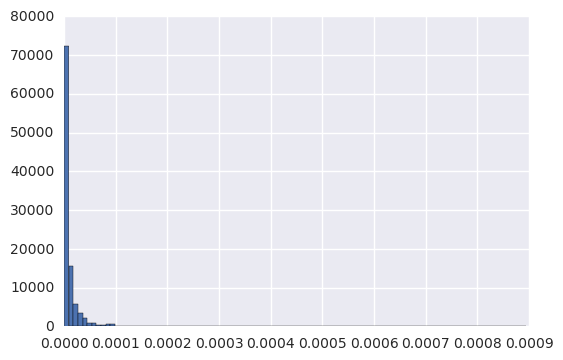

In [125]:
probability_vector.hist(bins=100)

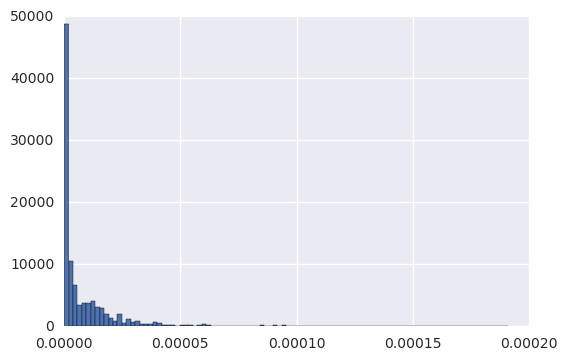

In [126]:
probability_vector[probability_vector < 0.0002].hist(bins=100)

In [127]:
probability_vector[probability_vector > 0.0001] = 0.0001

In [128]:
probability_vector /= probability_vector.sum()

In [85]:
number_of_customers = 200
customer_node_ids = np.random.choice(len(probability_vector), 
                                         number_of_customers, 
                                         p=probability_vector, 
                                         replace=False)

In [145]:
helpers.export_graph(G, "./cph_center_200cust.ntw", 111, customer_node_ids)

In [ ]:
# probability vector is a probability of picking from a particular region

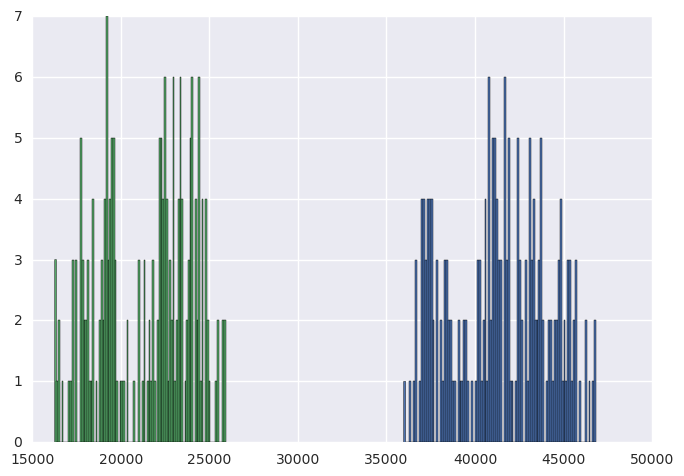

In [86]:
# check if customers distributed uniformly
lat = []
lon = []
for i in customer_node_ids:
    lat.append(float(G.node[i]['lat']))
    lon.append(float(G.node[i]['lon']))
pd.Series(lat).hist(bins=100)
pd.Series(lon).hist(bins=100)

# Plotting

/home/alogins/.local/lib/python3.4/site-packages/geopandas/plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


KeyError: 'dens'

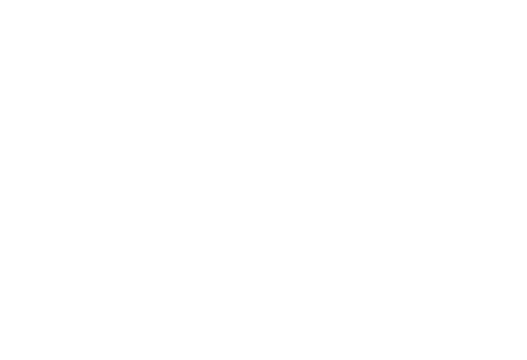

In [129]:
fig, ax1 = plt.subplots(1, dpi=300)
ax1.set_axis_off()
glaciers.plot(categorical=False,column="dens",colormap="Blues",ax=ax1, legend=True)

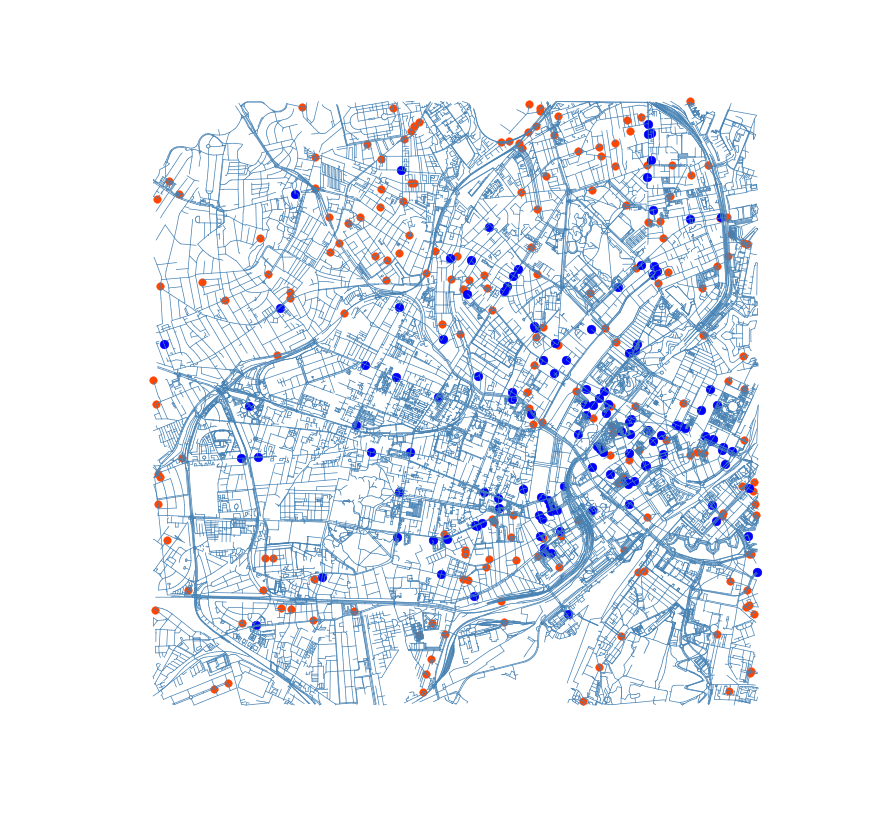

In [88]:
# print customers (shops)

#get customers
facility_coords = []
for key in hour_attr:
    facility_coords.append((G.node[key]['lat'], G.node[key]['lon']))

plt.figure(dpi=300,figsize=(10,10))
plt.axis('off')
        
for edge in nx.edges_iter(G):
    t = G[edge[0]][edge[1]]['etype'] 
#     plt.plot([G.node[edge[0]]['lat'],G.node[edge[1]]['lat']],
#              [G.node[edge[0]]['lon'],G.node[edge[1]]['lon']],color=color_map[t],linewidth=0.5)
    plt.plot([G.node[edge[0]]['lat'],G.node[edge[1]]['lat']],
             [G.node[edge[0]]['lon'],G.node[edge[1]]['lon']],color="steelblue",linewidth=0.5)

# tmp = []
# for node in nx.nodes_iter(G):
#     if len(G.node[node]) > 0:
#         tmp.append([G.node[node]['lat'],G.node[node]['lon']])
# tmp = np.array(tmp).T
# plt.scatter(tmp[0],tmp[1],marker='.',s=3)

tmp = []
for node in customer_node_ids:
    tmp.append([G.node[node]['lat'],G.node[node]['lon']])
tmp = np.array(tmp).T
plt.scatter(tmp[0],tmp[1],marker='o',color="orangered",s=30)
    

tmp = np.array(facility_coords).T
plt.scatter(tmp[0],tmp[1],marker='o',color="blue",s=40)